# Simple example

Here we cover a very simple example of subject-independent single-trial classification on a motor execution task.

&rarr; [Download this notebook](https://gitlab.com/HanBnrd/benchnirs/-/raw/main/docs/source/examples/simple-example.ipynb?ref_type=heads&inline=false)

## Import the BenchNIRS package

In [1]:
import benchnirs as bn

The *BenchNIRS* version number can be displayed with `print(bn.__version__)`.

## Download one of the datasets

[Download](https://figshare.com/ndownloader/files/18069143) and unzip the open-access motor execution dataset (*N*=30) from [Bak et al. 2019](https://doi.org/10.3390/electronics8121486), consisting of fNIRS recordings under 3 conditions (left-hand finger tapping, right-hand finger tapping, and foot tapping).

## Load the dataset

In [2]:
epochs = bn.load_dataset(
    'bak_2019_me', path='./dataset_bak_2019',
    bandpass=[0.01, 0.5], tddr=True, roi_sides=True
)
print(epochs)

Loading data: 100%|######################################################| Subject 30/30


<Epochs |  4470 events (all good), -1.95 – 9.95 s, baseline -1.95 – 0 s, ~20.5 MB, data loaded, with metadata,
 'right': 750
 'left': 750
 'foot': 750
 'unlabelled': 2220>


## Prepare the data for model training

In [3]:
nirs, labels, subjects = bn.process_epochs(epochs['left', 'right', 'foot'])

Event-to-label mapping: {'right': 0, 'left': 1, 'foot': 2}
Subject-to-group mapping: {'fNIRS 01': 0, 'fNIRS 02': 1, 'fNIRS 03': 2, 'fNIRS 04': 3, 'fNIRS 05': 4, 'fNIRS 06': 5, 'fNIRS 07': 6, 'fNIRS 08': 7, 'fNIRS 09': 8, 'fNIRS 10': 9, 'fNIRS 11': 10, 'fNIRS 12': 11, 'fNIRS 13': 12, 'fNIRS 14': 13, 'fNIRS 15': 14, 'fNIRS 16': 15, 'fNIRS 17': 16, 'fNIRS 18': 17, 'fNIRS 19': 18, 'fNIRS 20': 19, 'fNIRS 21': 20, 'fNIRS 22': 21, 'fNIRS 23': 22, 'fNIRS 24': 23, 'fNIRS 25': 24, 'fNIRS 26': 25, 'fNIRS 27': 26, 'fNIRS 28': 27, 'fNIRS 29': 28, 'fNIRS 30': 29}
Dataset shape: (2250, 4, 100)


## Train a machine learning classifier

Train an [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) classifier (architecture from the benchmarking in [Benerradi et al. 2023](https://doi.org/10.3389/fnrgo.2023.994969)) and select the best hyperparameters:

In [4]:
acc, hps, additional_metrics = bn.deep_learn(
    'lstm', nirs, labels, subjects,
    lrs=[0.0001, 0.00001], batch_sizes=[64, 128],
    max_epochs=30, min_epochs=15
)
# Note: this is a toy example with a limited hyperparameter tuning
print(f"Average accuracy: {acc.mean()}")
print(f"Selected hyperparameters (mini-batch size, learning rate): {hps}")

Deep learning: _LSTMClassifier (using CPU)
    Training outer fold #0
    > Hyperparameter selection


    Training outer fold #1
    > Hyperparameter selection


    Training outer fold #2
    > Hyperparameter selection


    Training outer fold #3
    > Hyperparameter selection


    Training outer fold #4
    > Hyperparameter selection


    Testing outer fold #0
    > Test set subject(s): {4, 9, 14, 19, 24, 29}
    Testing outer fold #1
    > Test set subject(s): {5, 10, 15, 20, 25, 28}
    Testing outer fold #2
    > Test set subject(s): {1, 6, 11, 16, 21, 26}
    Testing outer fold #3
    > Test set subject(s): {2, 7, 12, 17, 22, 27}
    Testing outer fold #4
    > Test set subject(s): {0, 3, 8, 13, 18, 23}


Average accuracy: 0.5075555555555555
Selected hyperparameters (mini-batch size, learning rate): [(64, 0.0001), (64, 0.0001), (64, 0.0001), (128, 0.0001), (64, 0.0001)]


More figures and detailed results can be found in the newly created `./outputs/` folder.

> **Note**: *The .pickle and .pt files are model training checkpoints that enable to resume an interrupted training.*

## Train a custom model

Define a custom [ANN](https://en.wikipedia.org/wiki/Neural_network_(machine_learning)) architecture with [PyTorch](https://pytorch.org/):

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ANNClassifier(nn.Module):

    def __init__(self, n_classes):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(400, 250)
        self.fc2 = nn.Linear(250, 150)
        self.fc3 = nn.Linear(150, 60)
        self.fc4 = nn.Linear(60, n_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Train the defined model architecture and select the best hyperparameters:

Deep learning: ANNClassifier (using CPU)
    Training outer fold #0
    > Hyperparameter selection


    > Early stopping after 20 epochs


    Training outer fold #1
    > Hyperparameter selection


    > Early stopping after 22 epochs
    Training outer fold #2
    > Hyperparameter selection


    > Early stopping after 29 epochs


    Training outer fold #3
    > Hyperparameter selection


    Training outer fold #4
    > Hyperparameter selection


    > Early stopping after 16 epochs


    Testing outer fold #0
    > Test set subject(s): {4, 9, 14, 19, 24, 29}
    Testing outer fold #1
    > Test set subject(s): {5, 10, 15, 20, 25, 28}
    Testing outer fold #2
    > Test set subject(s): {1, 6, 11, 16, 21, 26}
    Testing outer fold #3
    > Test set subject(s): {2, 7, 12, 17, 22, 27}
    Testing outer fold #4
    > Test set subject(s): {0, 3, 8, 13, 18, 23}


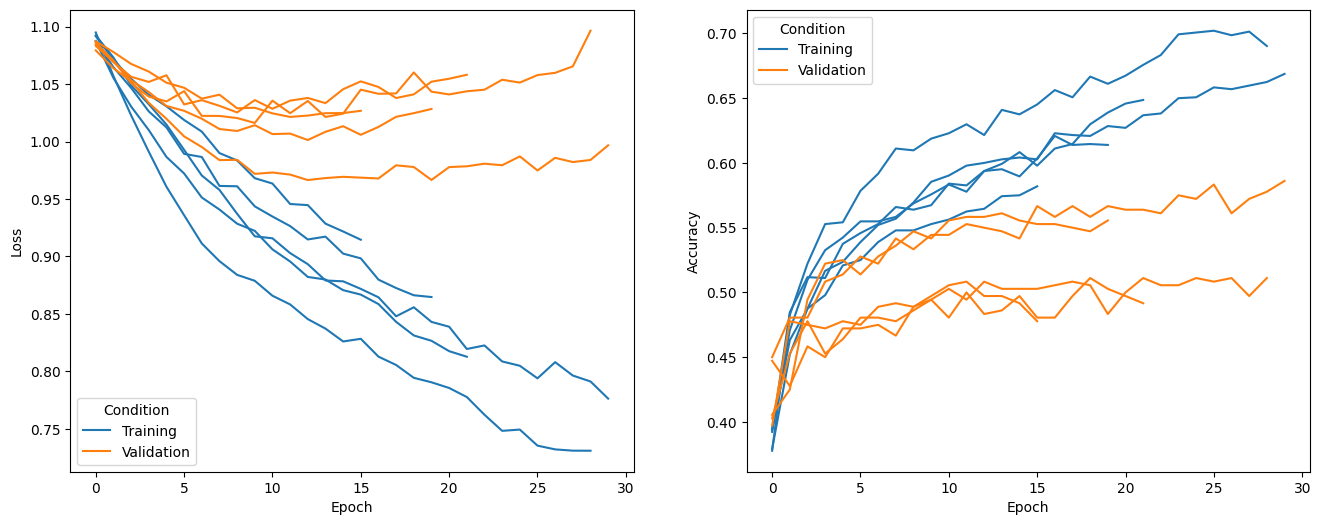

Average accuracy: 0.5306666666666666
Selected hyperparameters (mini-batch size, learning rate): [(128, 0.0001), (64, 0.0001), (64, 0.0001), (128, 0.0001), (128, 0.0001)]


In [6]:
acc, hps, additional_metrics = bn.deep_learn(
    ANNClassifier, nirs, labels, subjects,
    lrs=[0.0001, 0.00001], batch_sizes=[64, 128],
    max_epochs=30, min_epochs=15,
    output_folder='./outputs_custom'
)
# Note: this is a toy example with a limited hyperparameter tuning
print(f"Average accuracy: {acc.mean()}")
print(f"Selected hyperparameters (mini-batch size, learning rate): {hps}")

More figures and detailed results can be found in the newly created `./outputs_custom/` folder.

## Retrain a final model for deployment

Using insights from the previously performed hyperparameter selection and evaluation, train a final model:

In [7]:
classifier = bn.train_final(
    ANNClassifier, nirs, labels,
    batch_size=128, lr=0.0001, n_epochs=25,
    output_folder='./outputs_custom'
)
print(classifier)

Final training: ANNClassifier (using CPU)


Model training: 100%|######################################################| Epoch 25/25


ANNClassifier(
  (fc1): Linear(in_features=400, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=3, bias=True)
)


> **Note**: *This can be useful to later deploy the model and use if for inference.*